In [1]:
import ee   # Google EarthEngine API

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
ee.Initialize()

In [4]:
import os, sys
sys.path.append('../')
from dep.mask import bitmask_unpack, bit2mask

# sample a point from image

In [3]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


In [6]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 300).first().get('elevation').getInfo()
print('Mount Everest elevation (m), sampling from a larger area:', elev)

Mount Everest elevation (m), sampling from a larger area: 8678


# Select a series from AVHRR

In [5]:
avhrr_col = ee.ImageCollection('NOAA/CDR/AVHRR/SR/V5')
avhrr_b2 = avhrr_col.filter(ee.Filter.date('1985-01-01', '1986-01-01')).select('SREFL_CH2')

In [6]:
zunyi = [107,28]  # sub-tropical
hlj = [129, 47.5] # temperate
amazon1 = [-65, -5] # tropical rainforest

In [12]:
# select a point 
point = ee.Geometry.Point(amazon1)  # lon-lat
geom_val = avhrr_b2.filterBounds(
    point).getRegion(
    geometry=point, scale=30)

In [13]:
# Not necessary to convert to ee.List
geom_val_list = ee.List(geom_val).getInfo()

In [14]:
df1 = pd.DataFrame(geom_val_list[1:], columns = geom_val_list[0])

In [15]:
df1['datetime'] = pd.to_datetime(df1['time'], unit='ms', utc=True)

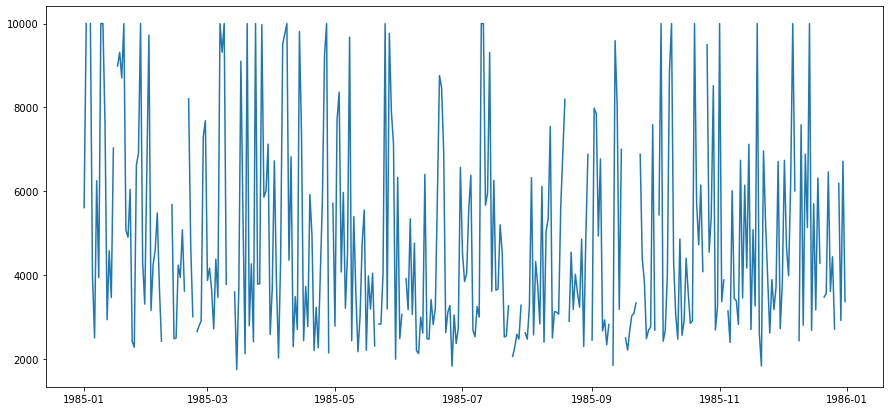

In [16]:
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(df1['datetime'], df1['SREFL_CH2'])

# Select multiple AVHRR series, apply mask

In [5]:
avhrr_col = ee.ImageCollection('NOAA/CDR/AVHRR/SR/V5')
avhrr_b1 = avhrr_col.filter(ee.Filter.date('1985-01-01', '1986-01-01')).select('SREFL_CH1')
avhrr_b2 = avhrr_col.filter(ee.Filter.date('1985-01-01', '1986-01-01')).select('SREFL_CH2')
avhrr_qa = avhrr_col.filter(ee.Filter.date('1985-01-01', '1986-01-01')).select('QA')

In [53]:
def get_point(band_obj, point, scale = 30):
    point_val = band_obj.filterBounds(
    point).getRegion(geometry=point, scale = scale)
    val_list = ee.List(point_val).getInfo()
    val_df = pd.DataFrame(val_list[1:], columns = val_list[0])
    return val_df

In [54]:
zunyi = [107,28]  # sub-tropical
hlj = [129, 47.5] # temperate
amazon1 = [-65, -5] # tropical rainforest

In [55]:
# select a point 
point = ee.Geometry.Point(hlj)  # lon-lat

In [56]:
dfb2 = get_point(avhrr_b2, point, scale=10000)
dfqa = get_point(avhrr_qa, point, scale=10000)

In [57]:
dfb2['qa'] = dfqa['QA']

In [58]:
dfb2['datetime'] = pd.to_datetime(dfb2['time'], unit='ms', utc=True)
# dfqa['datetime'] = pd.to_datetime(dfqa['time'], unit='ms', utc=True)

In [59]:
bit_list = [1,2]

In [60]:
maskarr = bit2mask(dfqa['QA'], bit_list)

In [61]:
dfb2['ch2_cldmsk'] = np.where(dfb2['SREFL_CH2'] * maskarr == 0, np.nan, dfb2['SREFL_CH2'] * maskarr)

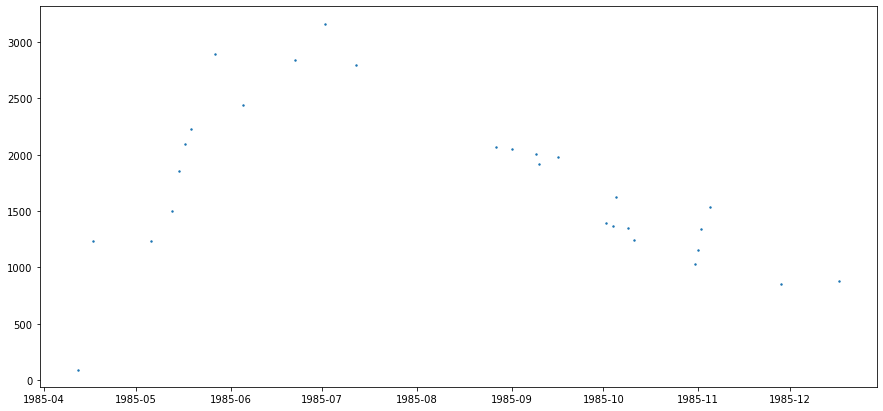

In [62]:
plt.rcParams['figure.figsize'] = (15,7)

plt.scatter(dfb2['datetime'], dfb2['ch2_cldmsk'], 2)

# Try NDVI

In [63]:
import folium

In [ ]:
ndvi = ee.Image(image).normalizedDifference(['SREFL_CH2','SREFL_CH1']).rename('NDVI')

In [67]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
    ).add_to(self)

In [76]:
2 or 4

2

In [93]:
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
    'min': -1,
    'max': 1,
    }
#'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3)

# Add the elevation model to the map object.
avhrr_col = ee.ImageCollection('NOAA/CDR/AVHRR/SR/V5')
avhrr_1 = avhrr_col.filter(ee.Filter.date('1985-07-01', '1985-07-05')).first()  # do not select bands

qa = avhrr_1.select('QA')
cldmsk = 1 << 1   # cloud
cldsmsk = 1 << 2  # cloud shadow
mask = (qa.bitwiseAnd(cldmsk).eq(0)).And(qa.bitwiseAnd(cldsmsk).eq(0))  
mask1 = qa.bitwiseAnd(cldmsk).eq(0)
ndvi = avhrr_1.normalizedDifference(['SREFL_CH2','SREFL_CH1']).rename('NDVI')
ndvi_m = ndvi.updateMask(mask)
ndvi_cldmsk = ndvi.updateMask(mask1)

my_map.add_ee_layer(ndvi_m, vis_params, 'AVHRR_B2')
my_map.add_ee_layer(ndvi_cldmsk, vis_params, 'AVHRR_B2_only_cloudmask')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [ ]:
# evi = ee.Image(image).expression(
#       'float(2.5*(((B4/10000) - (B3/10000)) / ((B4/10000) + (6 * (B3/10000)) - (7.5 * (B1/10000)) + 1)))',
#       {
#           'B4': ee.Image(image).select(['NIR']),
#           'B3': ee.Image(image).select(['RED']),
#           'B1': ee.Image(image).select(['BLUE'])
#       }).rename('EVI')